# Table of Contents
- [Data](#Data)
    - Loading the dataset
    - Pre-processing the data
    - Visualizing the First 21 Training Images
    
    
- [Implementation](#Implementation)
    - Without transfer learning
    - With transfert learning

In [2]:
import tensorflow
tensorflow.__version__

'1.7.0'

In [3]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [130]:
from tools import *

In [7]:
# Test if the GPU are being used (should output non empty list)
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

# Data
---

## Loading the dataset

The data used to train the classifier comes from the [INRIA person dataset](http://pascal.inrialpes.fr/data/human/), or VOC2012

Direct link: [download](ftp://ftp.inrialpes.fr/pub/lear/douze/data/INRIAPerson.tar)  (970MBB tar file)

In [8]:
# Remove the files that won't be used in the project
rm_unused_folders('INRIAPerson/')

# Initialy the INRIA person dataset doesn't contain a Valid folder
create_validation_data_folder('INRIAPerson/', proportion=0.3)

In [9]:
# Load train and test datasets
train_files, train_targets, classes = load_dataset('INRIAPerson/Train/')
valid_files, valid_targets, classes = load_dataset('INRIAPerson/Valid/')
test_files , test_targets , classes = load_dataset('INRIAPerson/Test/')

In [10]:
# Statistics about the dataset
stats(classes, train_targets, valid_targets, test_targets)

Classes: ['neg', 'pos']
Total images 		:  1744
Training images 	:  855  	 =  423 pos + 432 neg
Validation images 	:  365  	 =  189 pos + 176 neg
Test images 		:  524  	 =  288 pos + 236 neg


## Visualising the data

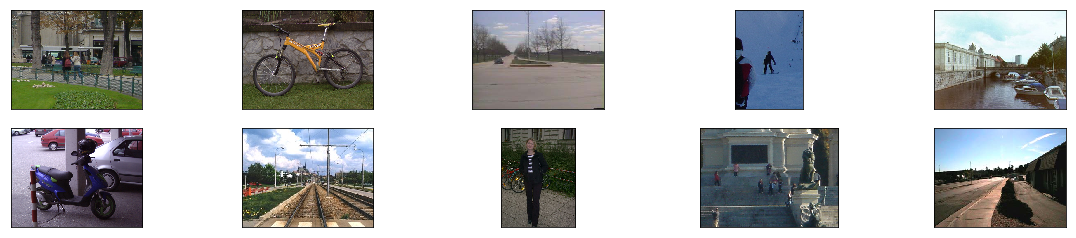

In [11]:
show_examples(train_files, number=10)

## Pre-processing the data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape:

$$
(\text{nb_samples}, \ \text{rows}, \ \text{columns}, \ \text{channels})
$$

- `nb_samples` = total number of images (or samples)
- `rows`, `columns`, `channels` = number of rows, columns, channels for each image, respectively 

In [12]:
train_tensors = paths_to_tensor(train_files)
valid_tensors = paths_to_tensor(valid_files)
test_tensors  = paths_to_tensor(test_files)

100%|██████████| 524/524 [00:07<00:00, 70.38it/s]


# Implementation
---

## Without transfer learning

### Model

The architecture used here (recomanded by Keras for [classification with little data](https://blog.keras.io/index.html)) consists in a simple stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers. With the exception of ReLU, this is similar to the architectures that Yann LeCun advocated in the 1990s for image classification.

- We use `ReLU` activation functions to solve the vanishing gradient problem.
- We use `MaxPooling` to reduce the dimentionality after each convolution layer.
- We finish with two dense layers. The last layer has 133 nodes since there are 133 possible categories.
- Since we are constructing a multi-class classification we use `softmax` as the activation function of the last dense layer. 
- We use [L2 regularization](https://keras.io/regularizers/) and [Batch Normalization](https://keras.io/layers/normalization/) to tackle overfitting.

In [107]:
from models import mobilenet, vgg16, resnet50

In [108]:
model, name_of_final_conv_layer, name_of_dense_layer = mobilenet.get_model(nb_classes=len(classes), summary=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 16)      432       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 16)      64        
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 16)      0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 114, 114, 16)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 16)      144       
__________

### Training

In [116]:
model_name = 'MobileNet alpha=0.5 unfrozen=2 optimizer=adam'

epochs = 20
batch_size = 32
data_augmentation = False

model_name += ' epochs='            + str(epochs) \
            + ' batch_size='        + str(batch_size) \
            + ' data_augmentation=' + str(data_augmentation)

In [117]:
if data_augmentation: 
    # With data augmentation 
    history = train_generator(model, 
                            model_name, 
                            train_tensors, 
                            train_targets, 
                            valid_tensors, 
                            valid_targets,
                            train_folder ='INRIAPerson/Train', 
                            valid_folder ='INRIAPerson/Valid', 
                            epochs       = epochs, 
                            batch_size   = batch_size, 
                            verbose=[1,0])
else:
    # Without data augmentation 
    history = train(model, 
                            model_name, 
                            train_tensors, 
                            train_targets, 
                            valid_tensors, 
                            valid_targets, 
                            epochs     = epochs, 
                            batch_size = batch_size,  
                            verbose    = [1,0])


Epoch 00001: val_loss improved from inf to 0.11465, saving model to saved_model_weights/MobileNet alpha=0.5 unfrozen=2 optimizer=adam epochs=20 batch_size=32 data_augmentation=False.hdf5

Epoch 00002: val_loss improved from 0.11465 to 0.09744, saving model to saved_model_weights/MobileNet alpha=0.5 unfrozen=2 optimizer=adam epochs=20 batch_size=32 data_augmentation=False.hdf5

Epoch 00003: val_loss improved from 0.09744 to 0.07662, saving model to saved_model_weights/MobileNet alpha=0.5 unfrozen=2 optimizer=adam epochs=20 batch_size=32 data_augmentation=False.hdf5

Epoch 00004: val_loss improved from 0.07662 to 0.07016, saving model to saved_model_weights/MobileNet alpha=0.5 unfrozen=2 optimizer=adam epochs=20 batch_size=32 data_augmentation=False.hdf5

Epoch 00005: val_loss improved from 0.07016 to 0.06657, saving model to saved_model_weights/MobileNet alpha=0.5 unfrozen=2 optimizer=adam epochs=20 batch_size=32 data_augmentation=False.hdf5

Epoch 00006: val_loss improved from 0.06657

### Evaluation

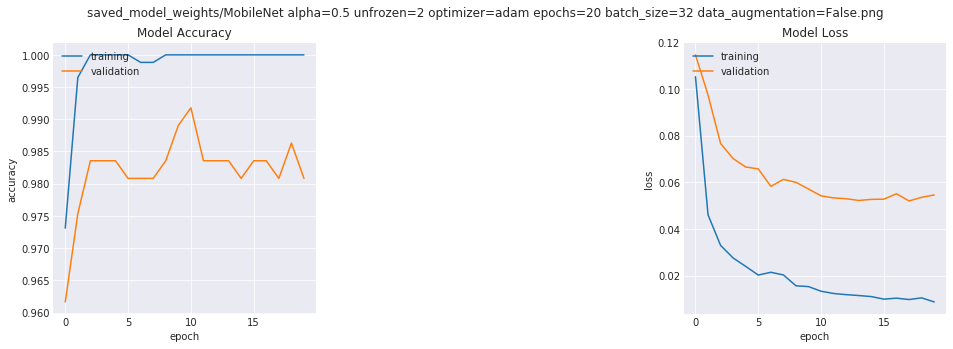

In [118]:
from IPython.display import Image
try:
    learning_curves(history, 'saved_model_weights/' + model_name + '.png')
except NameError:
    img = Image(filename='saved_model_weights/' + model_name + '.png') 
    display(img)

In [119]:
# Loading the model with the best validation loss
model.load_weights('saved_model_weights/' + model_name + '.hdf5')

In [120]:
compute_accuracy(model, test_tensors, test_targets)

Test accuracy: 97.3282%


In [153]:
from tools import *

In [136]:
quick_test_no_show(model, test_files, test_targets, 10)

INRIAPerson/Test/pos/crop001638.png
ground_truth =  human
prediction   =  human

INRIAPerson/Test/pos/person_and_bike_141.png
ground_truth =  human
prediction   =  human

INRIAPerson/Test/pos/crop001501.png
ground_truth =  human
prediction   =  human

INRIAPerson/Test/pos/person_and_bike_140.png
ground_truth =  human
prediction   =  human

INRIAPerson/Test/pos/person_065.png
ground_truth =  human
prediction   =  human

INRIAPerson/Test/neg/D2004-03-12_11h12m05s.jpg
ground_truth =  non-human
prediction   =  non-human

INRIAPerson/Test/neg/D2004-08-24_16h28m39s.jpg
ground_truth =  non-human
prediction   =  non-human

INRIAPerson/Test/neg/D2004-08-17_14h29m45s.jpg
ground_truth =  non-human
prediction   =  non-human

INRIAPerson/Test/neg/00001362.png
ground_truth =  non-human
prediction   =  non-human

INRIAPerson/Test/pos/person_135.png
ground_truth =  human
prediction   =  human



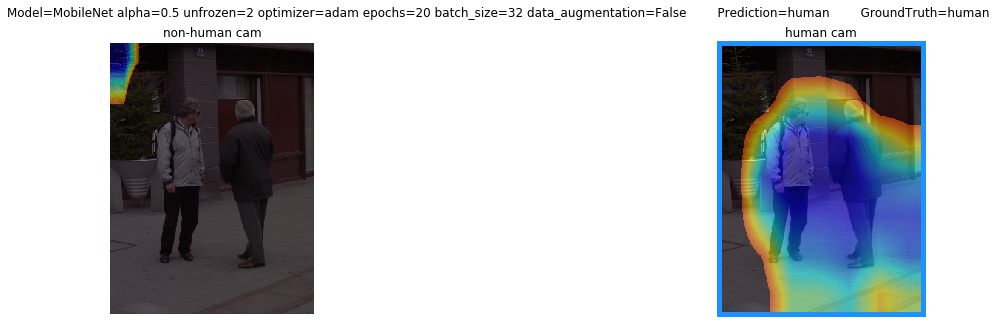

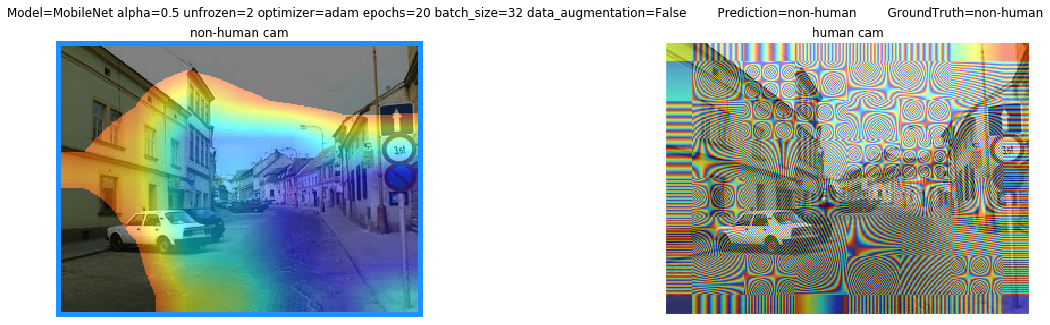

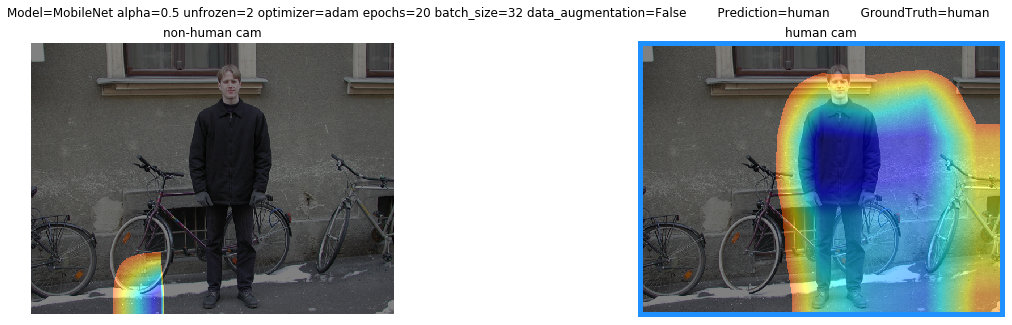

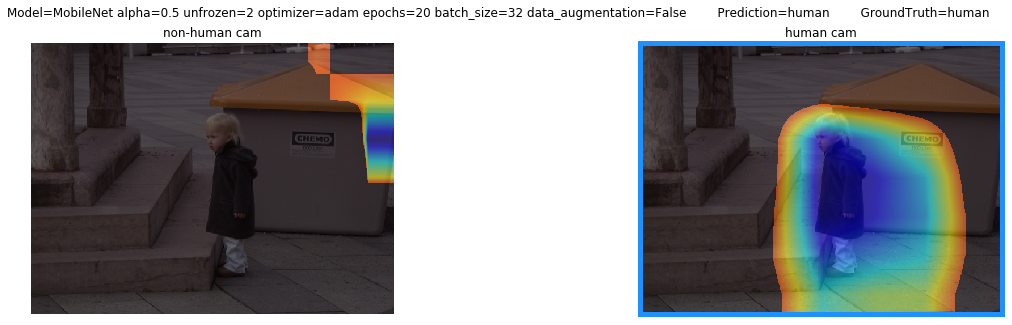

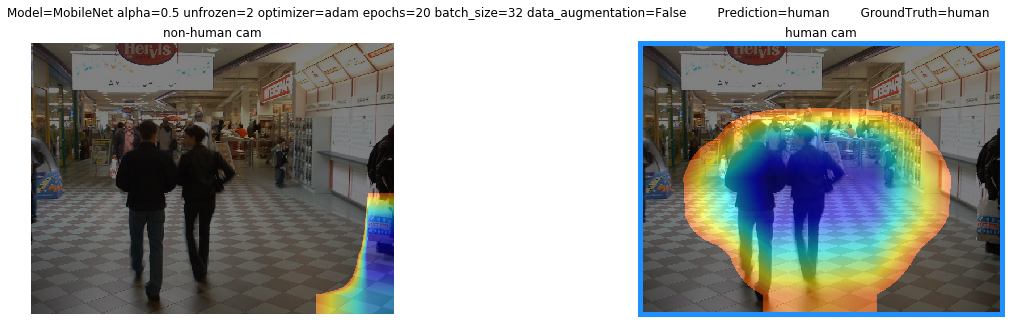

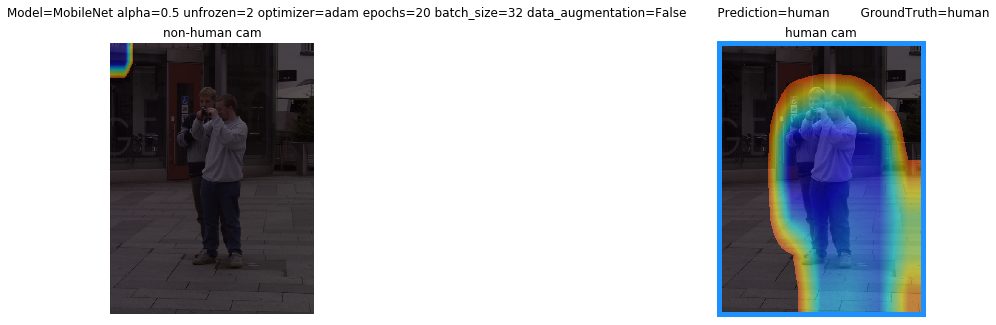

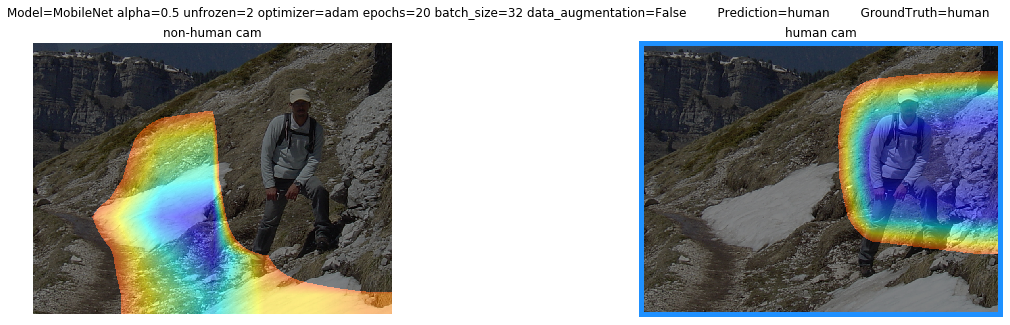

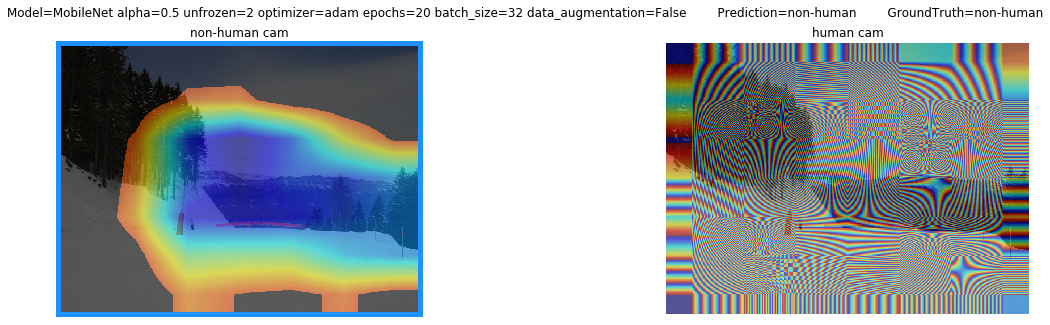

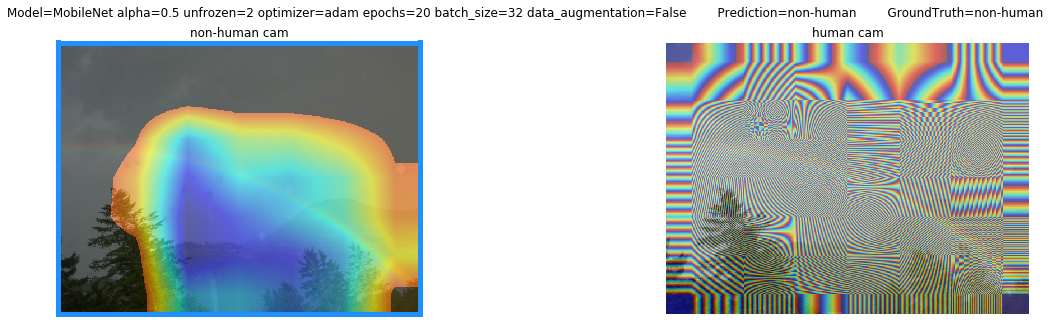

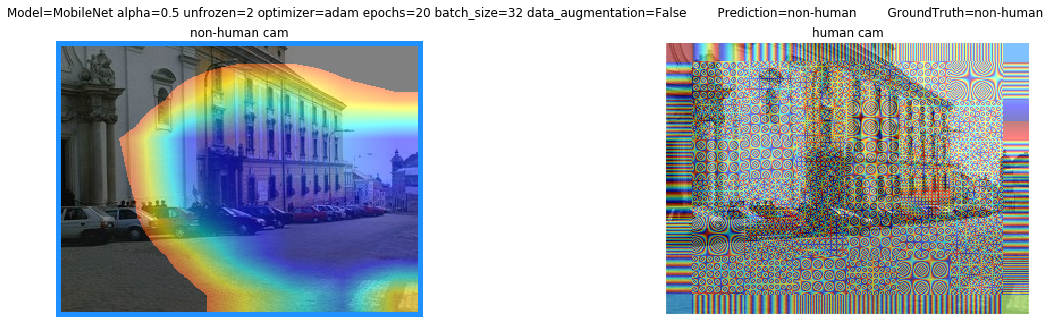

In [146]:
%matplotlib inline

name_of_final_conv_layer='conv_pw_13_relu'
name_of_dense_layer='dense_layer'
quick_test(model, model_name, test_files, test_targets, 10, name_of_final_conv_layer, name_of_dense_layer)

In [155]:
img_path = 'INRIAPerson/Test/pos/person_065.png'
img = cv2.imread(img_path)
img = cam(model, img, name_of_final_conv_layer, name_of_dense_layer, 1)

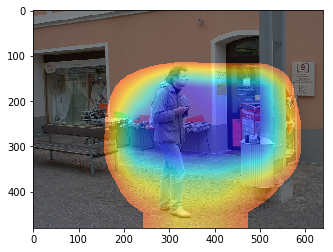

In [157]:
plt.imshow(img)
plt.show()